# Sberbank Housing Data

Import libraries
Load data
(Split in training/test)
Explore
Build baseline model
Build nnet using Tensorflow



In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [167]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
macro = pd.read_csv("data/macro.csv")

In [168]:
print(train.columns)

Index(['id', 'timestamp', 'full_sq', 'life_sq', 'floor', 'max_floor',
       'material', 'build_year', 'num_room', 'kitch_sq',
       ...
       'cafe_count_5000_price_2500', 'cafe_count_5000_price_4000',
       'cafe_count_5000_price_high', 'big_church_count_5000',
       'church_count_5000', 'mosque_count_5000', 'leisure_count_5000',
       'sport_count_5000', 'market_count_5000', 'price_doc'],
      dtype='object', length=292)


In [169]:
print(train.timestamp.max())
print(train.timestamp.min())

2015-06-30
2011-08-20


In [170]:
print(macro.timestamp.max())
print(macro.timestamp.min())

2016-10-19
2010-01-01


## Explore

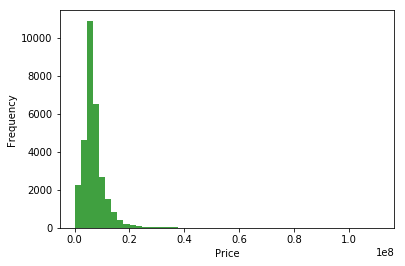

In [171]:
# Distribution of prices
train.price_doc

# the histogram of the data
plt.hist(train.price_doc, 50, facecolor='green', alpha=0.75)
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.show()


In [172]:
# Descriptive stats
print(train.price_doc.describe())

count    3.047100e+04
mean     7.123035e+06
std      4.780111e+06
min      1.000000e+05
25%      4.740002e+06
50%      6.274411e+06
75%      8.300000e+06
max      1.111111e+08
Name: price_doc, dtype: float64


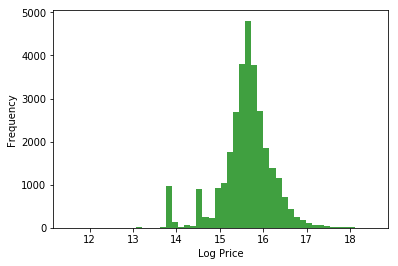

In [173]:
# Plot log transformed price
train['log_price'] = np.log(train['price_doc'])

# the histogram of the data
plt.hist(train.log_price, 50, facecolor='green', alpha=0.75)
plt.xlabel('Log Price')
plt.ylabel('Frequency')

plt.show()

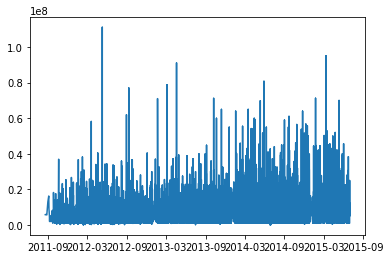

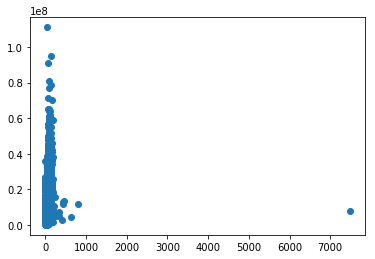

In [174]:
# Convert timestamp to datetime format
train.timestamp.describe()
pd.to_datetime(train.timestamp)

# Plot timestamp vs price
plt.plot(pd.to_datetime(train.timestamp), train.price_doc)
plt.show()

# Plot living area vs price
plt.scatter(train.life_sq, train.price_doc)
plt.show()

# Linear regression using TF


In [175]:
# Removing an outlier
i = train.life_sq > 7000
train.life_sq.loc[i] = np.NaN
train[i]

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc,log_price
13546,13549,2013-12-30,79,NaN,8.0,17.0,1.0,2014.0,3.0,1.0,...,0,0,1,7,1,0,12,1,7705000,15.85738


-0.0632642548229


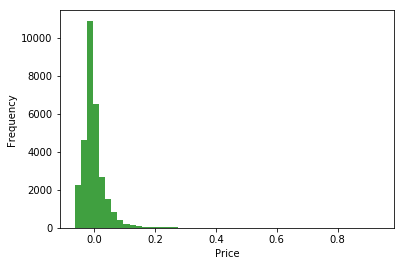

In [176]:
# Normalizing function
def normalize_x(x):
    x_norm = (x - x.mean()) / (x.max() - x.min())
    return(x_norm)

print(normalize_x(train.price_doc).min())

plt.hist(normalize_x(train.price_doc), 50, facecolor='green', alpha=0.75)
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.show()

In [177]:
train.life_sq.describe()
pd.isnull(train.life_sq).sum()

# Make a simple regression

# Create data vectors (filling na with median and normalize)
x_data = normalize_x(train.life_sq.fillna(train.life_sq.median()).as_matrix())
y_data = normalize_x(train.price_doc.as_matrix())


# Parameters
learning_rate = 0.01
training_epochs = 1000
cost_history = np.empty(shape=[1],dtype=float)

# Initiate weight and bias term
#W = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
#b = tf.Variable(tf.random_uniform([1], -1.0, 1.0))
W = tf.Variable(tf.ones([1,1]))
b = tf.Variable(tf.ones([1,1]))

# Placeholders for data tensors
X = tf.placeholder(tf.float32)
Y = tf.placeholder(tf.float32)

# Hypothesis function
hypothesis = W * X + b

# Cost function
cost = tf.reduce_mean(tf.square(hypothesis - Y))

a = tf.Variable(learning_rate)
optimizer = tf.train.GradientDescentOptimizer(learning_rate)
training = optimizer.minimize(cost)

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

for step in range(training_epochs):
    sess.run(training, feed_dict={X: x_data, Y: y_data})
    cost_history = np.append(cost_history, sess.run(cost, feed_dict={X: x_data, Y: y_data}))
    #if step % 20 == 0:
    #    print(step, sess.run(cost, feed_dict={X: x_data, Y: y_data}), sess.run(W), sess.run(b))

print(sess.run(hypothesis, feed_dict={X: 5}))
print(sess.run(hypothesis, feed_dict={X: 2.5}))


[[ 4.98502159]]
[[ 2.4925108]]


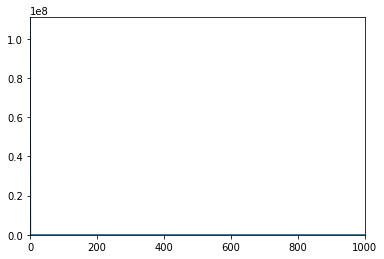

In [178]:
plt.plot(range(len(cost_history)),cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

MSE: 0.0016


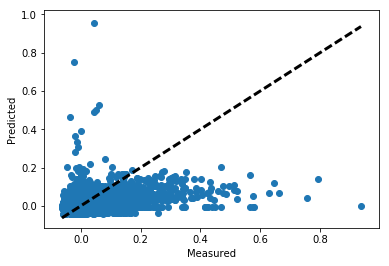

In [179]:
pred_y = sess.run(hypothesis, feed_dict={X: x_data})
mse = tf.reduce_mean(tf.square(pred_y - y_data))
print("MSE: %.4f" % sess.run(mse)) 

fig, ax = plt.subplots()
ax.scatter(y_data, pred_y)
ax.plot([y_data.min(), y_data.max()], [y_data.min(), y_data.max()], 'k--', lw=3)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [180]:
cost_history

array([  1.11011112e+08,   9.62017179e-01,   9.23985422e-01, ...,
         1.61806494e-03,   1.61806389e-03,   1.61806296e-03])